Loading and preprocessing data...
Data shape: (1428729, 16)
Labels shape: (1428729,)
Original unique labels: [ 0  1  3  4  6  9 10 11]
Gesture labels (excluding rest): [ 1  3  4  6  9 10 11]
Number of gesture classes: 7
Label mapping: {1: 0, 3: 1, 4: 2, 6: 3, 9: 4, 10: 5, 11: 6}
Window shape example: (16,)
Training loader shape: 2
Training samples: 6816
Validation samples: 1704
Test samples: 2130
Num features: 16
Model initialized with 16 input features and 7 classes
Total parameters: 223815

Starting training...
Epoch [10/100], Train Loss: 0.9725, Val Accuracy: 62.38%
Epoch [20/100], Train Loss: 0.8433, Val Accuracy: 68.78%
Epoch [30/100], Train Loss: 0.7672, Val Accuracy: 69.95%
Epoch [40/100], Train Loss: 0.7064, Val Accuracy: 70.95%
Epoch [50/100], Train Loss: 0.6680, Val Accuracy: 71.19%
Epoch [60/100], Train Loss: 0.6237, Val Accuracy: 71.48%
Epoch [70/100], Train Loss: 0.5921, Val Accuracy: 70.83%
Epoch [80/100], Train Loss: 0.5594, Val Accuracy: 72.54%
Epoch [90/100], Train Los

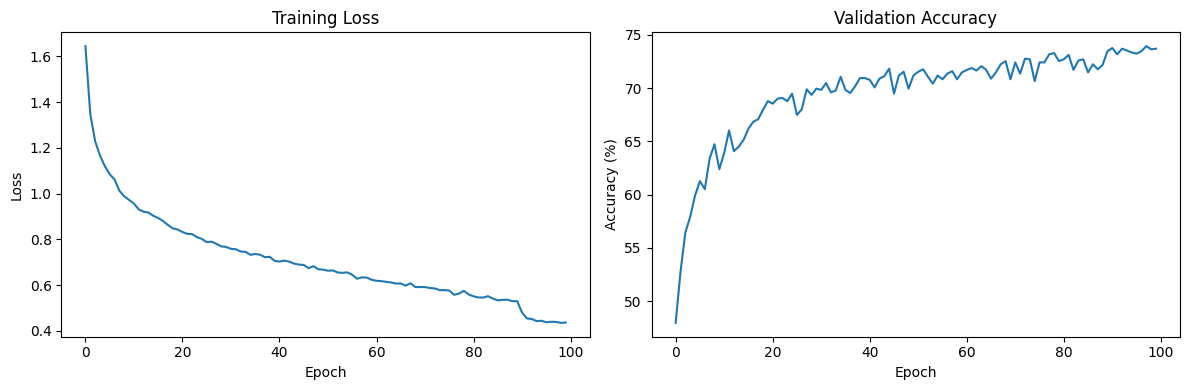


Model saved as 'tcn_ninapro_model.pth'


In [1]:
# 데이터셋 먼저 NinaDataset전환 후 train, test, val dataset으로 split
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
from typing import Tuple, List
from scipy.signal import butter, filtfilt
from torch.nn.utils.parametrizations import weight_norm
from utils.tcn_helper import TCN


class NinaProDataset(Dataset):
    """
    Dataset class for NinaPro data
    """
    def __init__(self, data: np.ndarray, labels: np.ndarray, window_size: int = 200, label_mapping: dict = None):
        self.data = data
        self.labels = labels
        self.window_size = window_size
        self.label_mapping = label_mapping
        
        # Create sliding windows
        self.windows, self.window_labels = self._create_windows()
        print("Window shape example:", self.windows[0].shape)
        
    def _create_windows(self):
        windows = []
        window_labels = []
        stride = self.window_size // 2

        for i in range(0, len(self.data) - self.window_size + 1, stride):
            window = self.data[i:i + self.window_size]
            # Use the label of the center point of the window
            label = self.labels[i + self.window_size - 1]
            
            # Skip rest periods (label 0 in NinaPro)
            if label > 0:
                rms_features = np.sqrt(np.mean(window ** 2, axis=0))  # shape: (n_features,)
                windows.append(rms_features)

                mapped_label = self.label_mapping[label] if self.label_mapping else label - 1
                window_labels.append(mapped_label)
                
        return np.array(windows), np.array(window_labels)
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.windows[idx], dtype=torch.float32)
        y = torch.tensor(self.window_labels[idx], dtype=torch.long)
        return x, y


def load_ninapro_data(file_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load NinaPro .mat file
    
    Args:
        file_path: Path to the .mat file
        
    Returns:
        Tuple of (EMG data, labels)
    """
    mat_data = sio.loadmat(file_path)
    
    # Common key names in NinaPro dataset
    # Adjust these based on your specific dataset structure
    possible_emg_keys = ['emg', 'EMG', 'data']
    possible_label_keys = ['restimulus', 'stimulus', 'labels', 'rerepetition']
    
    emg_data = None
    labels = None
    
    # Find EMG data
    for key in possible_emg_keys:
        if key in mat_data:
            emg_data = mat_data[key]
            break
    
    # Find labels
    for key in possible_label_keys:
        if key in mat_data:
            labels = mat_data[key].flatten()
            break
    
    if emg_data is None or labels is None:
        print("Available keys in .mat file:")
        for key in mat_data.keys():
            if not key.startswith('__'):
                print(f"  {key}: {mat_data[key].shape if hasattr(mat_data[key], 'shape') else type(mat_data[key])}")
        raise ValueError("Could not find EMG data or labels. Please check the keys above.")
    
    return emg_data, labels

def bandpass_filter(signal, lowcut=20, highcut=450, fs=2000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=0)

def preprocess_data(emg_data: np.ndarray, labels: np.ndarray) -> Tuple[np.ndarray, np.ndarray, dict, int]:
    """
    Preprocess EMG data and labels
    """
    # Remove any NaN values
    valid_indices = ~np.isnan(emg_data).any(axis=1) & ~np.isnan(labels)
    emg_data = emg_data[valid_indices]
    labels = labels[valid_indices]

    # ✨ remove noise
    emg_data = bandpass_filter(emg_data, lowcut=20, highcut=450, fs=2000)
    
    # Normalize EMG data
    scaler = StandardScaler()
    emg_data = scaler.fit_transform(emg_data)
    
    # Create label mapping for continuous indexing
    unique_labels = np.unique(labels)
    # Remove rest label (0) if present
    gesture_labels = unique_labels[unique_labels > 0]
    
    # Create mapping from original labels to 0-based continuous labels
    label_mapping = {label: idx for idx, label in enumerate(gesture_labels)}
    num_classes = len(gesture_labels)
    
    print(f"Data shape: {emg_data.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Original unique labels: {unique_labels}")
    print(f"Gesture labels (excluding rest): {gesture_labels}")
    print(f"Number of gesture classes: {num_classes}")
    print(f"Label mapping: {label_mapping}")
    
    return emg_data, labels, label_mapping, num_classes


def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, 
                num_epochs: int = 100, lr: float = 0.001) -> Tuple[List[float], List[float]]:
    """
    Train the TCN model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
    
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for batch_data, batch_labels in train_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_labels.size(0)
                val_correct += (predicted == batch_labels).sum().item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.2f}%')
    
    return train_losses, val_accuracies


def evaluate_model(model: nn.Module, test_loader: DataLoader) -> Tuple[float, str]:
    """
    Evaluate the trained model
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions)
    
    return accuracy, report


def plot_training_history(train_losses: List[float], val_accuracies: List[float]):
    """
    Plot training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

class EMGWindowDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

def main():
    """
    Main training pipeline
    """
    # Configuration
    DATA_PATH = "../../data/DB6/DB6_s1_a/S1_D1_T1.mat"  # Update this path
    TEST_DATA_PATH = "../data/DB6/DB6_s1_a/S1_D1_T2.mat" 
    WINDOW_SIZE = 200  # Adjust based on your sampling rate and desired window length
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.001
    
    # TCN hyperparameters
    TCN_CHANNELS = [64, 64, 128, 128] 
    #[64, 64, 128, 128]  # Hidden layer sizes
    KERNEL_SIZE = 3
    DROPOUT = 0.2
    
    print("Loading and preprocessing data...")
    
    # Load data
    emg_data, labels = load_ninapro_data(DATA_PATH)
    emg_data, labels, label_mapping, num_classes = preprocess_data(emg_data, labels)
    
    dataset = NinaProDataset(emg_data, labels, WINDOW_SIZE, label_mapping)
    # Split data

    train_data, test_data, train_labels, test_labels = train_test_split(
        dataset.windows, dataset.window_labels, test_size=0.2, random_state=42, stratify=dataset.window_labels
    )
    
    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size=0.2, random_state=42, stratify=train_labels
    )
    
    train_dataset = EMGWindowDataset(train_data, train_labels)
    val_dataset = EMGWindowDataset(val_data, val_labels)
    test_dataset = EMGWindowDataset(test_data, test_labels)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    batch = next(iter(train_loader))
    print(f"Training loader shape: {len(batch)}")

     
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Initialize model
    num_features = emg_data.shape[1]

    print(f"Num features: {num_features}")
    model = TCN(num_inputs=num_features, 
                num_channels=TCN_CHANNELS,
                num_classes=num_classes,
                kernel_size=KERNEL_SIZE,
                dropout=DROPOUT)
    
    print(f"Model initialized with {num_features} input features and {num_classes} classes")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
    
    # Train model
    print("\nStarting training...")
    train_losses, val_accuracies = train_model(model, train_loader, val_loader, 
                                             NUM_EPOCHS, LEARNING_RATE)
    
    # Evaluate model
    print("\nEvaluating on test set...")
    test_accuracy, classification_rep = evaluate_model(model, test_loader)
    
    print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_rep)
    
    # Plot training history
    plot_training_history(train_losses, val_accuracies)
    
    # Save model and label mapping
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_mapping': label_mapping,
        'num_classes': num_classes,
        'num_features': num_features
    }, 'tcn_ninapro_model.pth')
    print("\nModel saved as 'tcn_ninapro_model.pth'")
    
    return model, label_mapping


if __name__ == "__main__":
    main()

In [3]:
   # Evaluate model
print("\nEvaluating on test set...")
test_accuracy, classification_rep = evaluate_model(model, test_loader)
    
print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_rep)


Evaluating on test set...


NameError: name 'model' is not defined